In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data"))

# Any results you write to the current directory are saved as output.

['._sample_submission.csv', 'new_merchant_transactions.csv', '._historical_transactions.csv', '._Data_Dictionary.xlsx', '._new_merchant_transactions.csv', 'sample_submission.csv', 'merchants.csv', 'historical_transactions.csv', '._test.csv', 'train.csv', '._train.csv', '._merchants.csv', 'test.csv', 'Data_Dictionary.xlsx']


In [2]:
#an attempt to use embedding for tabular data
# thanks to https://www.kaggle.com/artgor/nn-baseline, https://www.kaggle.com/hrmello/starter-neural-network-3-939-lb
# and kaggle kernel on feature engineering like https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo and others

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras_tqdm import TQDMNotebookCallback

import os

import tensorflow as tf
import keras as K
print(tf.__version__)
print(K.__version__)
print(tf.keras.__version__)

SEED = 2018


Using TensorFlow backend.


1.4.0
2.2.4
2.0.8-tf


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import Ridge

from sklearn import preprocessing
import warnings
import datetime
warnings.filterwarnings("ignore")
import gc

from scipy.stats import describe
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


In [5]:
#Loading Train and Test Data
train = pd.read_csv("data/train.csv", parse_dates=["first_active_month"])
test = pd.read_csv("data/test.csv", parse_dates=["first_active_month"])
print("{} observations and {} features in train set.".format(train.shape[0],train.shape[1]))
print("{} observations and {} features in test set.".format(test.shape[0],test.shape[1]))

201917 observations and 6 features in train set.
123623 observations and 5 features in test set.


In [6]:
train["month"] = train["first_active_month"].dt.month
test["month"] = test["first_active_month"].dt.month
train["year"] = train["first_active_month"].dt.year
test["year"] = test["first_active_month"].dt.year
train['elapsed_time'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
test['elapsed_time'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,92


In [7]:
hist_trans = pd.read_csv("data/historical_transactions.csv")
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
hist_trans = pd.get_dummies(hist_trans, columns=['category_2', 'category_3'])
hist_trans['authorized_flag'] = hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
hist_trans['category_1'] = hist_trans['category_1'].map({'Y': 1, 'N': 0})
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,0,0,0,1,0,0


In [9]:
def aggregate_transactions(trans, prefix):  
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [10]:
import gc
merch_hist = aggregate_transactions(hist_trans, prefix='hist_')
del hist_trans
gc.collect()
train = pd.merge(train, merch_hist, on='card_id',how='left')
test = pd.merge(test, merch_hist, on='card_id',how='left')
del merch_hist
gc.collect()
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,elapsed_time,hist_transactions_count,...,hist_category_2_3.0_mean,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_category_2_4.0_mean,hist_month_lag_min,hist_month_lag_max,hist_merchant_id_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,245,260,...,0.0,4,0.015385,1,0,0.123314,0.000000,-8,0,94
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,396,350,...,0.0,543,1.551429,10,-1,1.510777,0.000000,-12,0,142
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,549,43,...,0.0,0,0.000000,0,0,0.000000,0.000000,-13,0,13
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,153,77,...,0.0,84,1.090909,3,-1,0.588974,0.688312,-5,0,50
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,92,133,...,0.0,182,1.368421,12,1,1.896862,0.804511,-3,0,66


In [11]:
new_trans = pd.read_csv("data/new_merchant_transactions.csv")
new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [12]:
new_trans = pd.get_dummies(new_trans, columns=['category_2', 'category_3'])
new_trans['authorized_flag'] = new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
new_trans['category_1'] = new_trans['category_1'].map({'Y': 1, 'N': 0})
new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,9,19,1,0,0,0,0,0,1,0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,9,19,1,0,0,0,0,0,1,0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,9,14,1,0,0,0,0,0,1,0
3,1,C_ID_415bb3a509,-1,1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,-1,8,0,0,0,0,0,0,1,0
4,1,C_ID_ef55cf8d4b,-1,1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,-1,29,0,0,0,0,0,0,1,0


In [13]:
merch_new = aggregate_transactions(new_trans, prefix='new_')
del new_trans
gc.collect()
train = pd.merge(train, merch_new, on='card_id',how='left')
test = pd.merge(test, merch_new, on='card_id',how='left')

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,elapsed_time,hist_transactions_count,...,new_category_2_3.0_mean,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_category_2_4.0_mean,new_month_lag_min,new_month_lag_max,new_merchant_id_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,245,260,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,2.0,23.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,396,350,...,0.000000,6.0,1.000000,1.0,1.0,0.000000,0.000000,1.0,2.0,6.0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,549,43,...,0.000000,0.0,0.000000,0.0,0.0,NaN,0.000000,2.0,2.0,1.0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,153,77,...,0.000000,5.0,0.714286,1.0,-1.0,0.755929,0.857143,1.0,2.0,7.0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,92,133,...,0.194444,35.0,0.972222,2.0,-1.0,0.376913,0.694444,1.0,2.0,36.0


In [14]:
del merch_new
gc.collect()

42

In [15]:
cat_cols = ['feature_1', 'feature_2', 'feature_3', 'month', 'year','hist_merchant_id_nunique']

In [16]:
target = train['target']
drops = ['card_id', 'first_active_month', 'target']
num_cols = [col for col in train.columns if col not in cat_cols and col not in drops]
total_cols = [col for col in train.columns]


In [17]:
from sklearn.preprocessing import LabelEncoder
max_values = {}
for col in cat_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))
    max_values[col] = max(train[col].max(), test[col].max())  + 2
    print(max_values[col])

feature_1
6
feature_2
4
feature_3
3
month
26
year
18
hist_merchant_id_nunique
333


In [18]:
# printing because I'm too lazy to write everything by hand. Open output to see.
for col in cat_cols:
    n = col.replace('.', '_')
    #print(f'{n} = Input(shape=[1], name="{col}")')
    #print(f'emb_{n} = Embedding({max_values[col]}, {(np.min(max_values[col]+1)//2, 50)})({col})')
    print(',', n)

, feature_1
, feature_2
, feature_3
, month
, year
, hist_merchant_id_nunique


In [19]:
#filter num values
target = train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols_num = [c for c in train.columns if c in num_cols]
features_num = list(train[use_cols_num].columns)
train[features_num].head()

,elapsed_time,hist_transactions_count,hist_category_2_1.0_mean,hist_purchase_date_ptp,hist_category_3_A_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,...,new_category_2_3.0_mean,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_category_2_4.0_mean,new_month_lag_min,new_month_lag_max,new_merchant_id_nunique
0,245,260,0.988462,20977987.0,0.984615,-165.968739,-0.638341,2.258395,-0.739395,0.212139,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,2.0,23.0
1,396,350,0.911429,33717687.0,0.000000,-210.006336,-0.600018,4.630299,-0.742400,0.384967,...,0.000000,6.0,1.000000,1.0,1.0,0.000000,0.000000,1.0,2.0,6.0
2,549,43,0.093023,35635623.0,1.000000,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,...,0.000000,0.0,0.000000,0.0,0.0,NaN,0.000000,2.0,2.0,1.0
3,153,77,0.155844,13375339.0,0.000000,-49.491364,-0.642745,1.445596,-0.740897,0.261624,...,0.000000,5.0,0.714286,1.0,-1.0,0.755929,0.857143,1.0,2.0,7.0
4,92,133,0.075188,9405641.0,0.000000,-48.687656,-0.366073,7.193041,-0.746156,1.352094,...,0.194444,35.0,0.972222,2.0,-1.0,0.376913,0.694444,1.0,2.0,36.0


In [20]:
#scale the data and impute the null values 
#note: apparently, GPU environment doesn't have an updated version of sklearn,
#so we cannot use sklearn.impute.SimpleImputer. In CPU environement this is possible
from sklearn.preprocessing import StandardScaler, Imputer
sc = StandardScaler()
train[features_num] = train[features_num].fillna(0)
train[features_num] = sc.fit_transform(train[features_num])

In [21]:
#fit test data
test[features_num] = test[features_num].fillna(0)
test[features_num] = sc.fit_transform(test[features_num])

In [22]:
#drop columns
X_train = train.drop([col for col in drops if col in train.columns], axis=1)
X_test = test.drop([col for col in drops if col in test.columns], axis=1)
X_train.shape

(201917, 58)

In [23]:
#renommer certaines colonnes
X_train.rename(columns={'hist_category_2_1.0_mean': 'hist_category_2_1_0_mean',
                        'hist_category_2_2.0_mean': 'hist_category_2_2_0_mean',
                        'hist_category_2_3.0_mean': 'hist_category_2_3_0_mean',
                        'hist_category_2_4.0_mean': 'hist_category_2_4_0_mean',
                        'hist_category_2_5.0_mean': 'hist_category_2_5_0_mean',
                        'new_category_2_1.0_mean': 'new_category_2_1_0_mean',
                        'new_category_2_2.0_mean': 'new_category_2_2_0_mean',
                        'new_category_2_3.0_mean': 'new_category_2_3_0_mean',
                        'new_category_2_4.0_mean': 'new_category_2_4_0_mean',
                        'new_category_2_5.0_mean': 'new_category_2_5_0_mean'}, inplace=True)
total_cols = [col for col in X_train.columns]
total_cols

['feature_1',
 'feature_2',
 'feature_3',
 'month',
 'year',
 'elapsed_time',
 'hist_transactions_count',
 'hist_category_2_1_0_mean',
 'hist_purchase_date_ptp',
 'hist_category_3_A_mean',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_std',
 'hist_category_3_C_mean',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_category_1_mean',
 'hist_category_3_B_mean',
 'hist_category_2_5_0_mean',
 'hist_category_2_2_0_mean',
 'hist_category_2_3_0_mean',
 'hist_installments_sum',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_category_2_4_0_mean',
 'hist_month_lag_min',
 'hist_month_lag_max',
 'hist_merchant_id_nunique',
 'new_transactions_count',
 'new_category_2_1_0_mean',
 'new_purchase_date_ptp',
 'new_category_3_A_mean',
 'new_purchase_amount_sum',
 'new_purchase_amount_mean',
 'new_purchase_amount_max',
 'new_purchas

In [24]:
#renommer certaines colonnes
X_test.rename(columns={'hist_category_2_1.0_mean': 'hist_category_2_1_0_mean',
                        'hist_category_2_2.0_mean': 'hist_category_2_2_0_mean',
                        'hist_category_2_3.0_mean': 'hist_category_2_3_0_mean',
                        'hist_category_2_4.0_mean': 'hist_category_2_4_0_mean',
                        'hist_category_2_5.0_mean': 'hist_category_2_5_0_mean',
                        'new_category_2_1.0_mean': 'new_category_2_1_0_mean',
                        'new_category_2_2.0_mean': 'new_category_2_2_0_mean',
                        'new_category_2_3.0_mean': 'new_category_2_3_0_mean',
                        'new_category_2_4.0_mean': 'new_category_2_4_0_mean',
                        'new_category_2_5.0_mean': 'new_category_2_5_0_mean'}, inplace=True)
total_cols = [col for col in X_test.columns]
total_cols

['feature_1',
 'feature_2',
 'feature_3',
 'month',
 'year',
 'elapsed_time',
 'hist_transactions_count',
 'hist_category_2_1_0_mean',
 'hist_purchase_date_ptp',
 'hist_category_3_A_mean',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_std',
 'hist_category_3_C_mean',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_category_1_mean',
 'hist_category_3_B_mean',
 'hist_category_2_5_0_mean',
 'hist_category_2_2_0_mean',
 'hist_category_2_3_0_mean',
 'hist_installments_sum',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_category_2_4_0_mean',
 'hist_month_lag_min',
 'hist_month_lag_max',
 'hist_merchant_id_nunique',
 'new_transactions_count',
 'new_category_2_1_0_mean',
 'new_purchase_date_ptp',
 'new_category_3_A_mean',
 'new_purchase_amount_sum',
 'new_purchase_amount_mean',
 'new_purchase_amount_max',
 'new_purchas

In [25]:
num_cols = [col for col in X_train.columns if col not in cat_cols and col not in drops]
num_cols

['elapsed_time',
 'hist_transactions_count',
 'hist_category_2_1_0_mean',
 'hist_purchase_date_ptp',
 'hist_category_3_A_mean',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_std',
 'hist_category_3_C_mean',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_category_1_mean',
 'hist_category_3_B_mean',
 'hist_category_2_5_0_mean',
 'hist_category_2_2_0_mean',
 'hist_category_2_3_0_mean',
 'hist_installments_sum',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_category_2_4_0_mean',
 'hist_month_lag_min',
 'hist_month_lag_max',
 'new_transactions_count',
 'new_category_2_1_0_mean',
 'new_purchase_date_ptp',
 'new_category_3_A_mean',
 'new_purchase_amount_sum',
 'new_purchase_amount_mean',
 'new_purchase_amount_max',
 'new_purchase_amount_min',
 'new_purchase_amount_std',
 'new_category_3_C_mean',
 'new_authorized_flag

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, BatchNormalization, Dropout, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from sklearn.model_selection import train_test_split
train_y = target.values
x_train, x_val, y_train, y_val = train_test_split(X_train, train_y, test_size = .1, random_state = SEED)

In [27]:
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss

from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#building the network

from keras.initializers import he_normal, he_uniform,  glorot_normal,  glorot_uniform
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D


In [28]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [29]:
def model(dense_dim_1=128, dense_dim_2=64, dense_dim_3=256, dense_dim_4=512,  dense_dim_5=512, dense_dim_6=256,
dropout1=0.1, dropout2=0.1, dropout3=0.2, dropout4=0.2, dropout5=0.2, dropout6=0.2, lr=0.0001):

    #Inputs cat
    feature_1 = Input(shape=[1], name="feature_1")
    feature_2 = Input(shape=[1], name="feature_2")
    feature_3 = Input(shape=[1], name="feature_3")
    month = Input(shape=[1], name="month")
    year = Input(shape=[1], name="year")
    hist_merchant_id_nunique = Input(shape=[1], name="hist_merchant_id_nunique")
    
    #Input num    
    elapsed_time = Input(shape=[1], name="elapsed_time")
    hist_transactions_count = Input(shape=[1], name="hist_transactions_count")
    hist_authorized_flag_sum = Input(shape=[1], name="hist_authorized_flag_sum")
    hist_authorized_flag_mean = Input(shape=[1], name="hist_authorized_flag_mean")
    hist_category_1_mean = Input(shape=[1], name="hist_category_1_mean")
    hist_category_2_1_0_mean = Input(shape=[1], name="hist_category_2_1_0_mean")
    hist_category_2_2_0_mean = Input(shape=[1], name="hist_category_2_2_0_mean")
    hist_category_2_3_0_mean = Input(shape=[1], name="hist_category_2_3_0_mean")
    hist_category_2_4_0_mean = Input(shape=[1], name="hist_category_2_4_0_mean")
    hist_category_2_5_0_mean = Input(shape=[1], name="hist_category_2_5_0_mean")
    hist_category_3_A_mean = Input(shape=[1], name="hist_category_3_A_mean")
    hist_category_3_B_mean = Input(shape=[1], name="hist_category_3_B_mean")
    hist_category_3_C_mean = Input(shape=[1], name="hist_category_3_C_mean")
    hist_purchase_amount_sum = Input(shape=[1], name="hist_purchase_amount_sum")
    hist_purchase_amount_mean = Input(shape=[1], name="hist_purchase_amount_mean")
    hist_purchase_amount_max = Input(shape=[1], name="hist_purchase_amount_max")
    hist_purchase_amount_min = Input(shape=[1], name="hist_purchase_amount_min")
    hist_purchase_amount_std = Input(shape=[1], name="hist_purchase_amount_std")
    hist_installments_sum = Input(shape=[1], name="hist_installments_sum")
    hist_installments_mean = Input(shape=[1], name="hist_installments_mean")
    hist_installments_max = Input(shape=[1], name="hist_installments_max")
    hist_installments_min = Input(shape=[1], name="hist_installments_min")
    hist_installments_std = Input(shape=[1], name="hist_installments_std")
    hist_purchase_date_ptp = Input(shape=[1], name="hist_purchase_date_ptp")
    hist_month_lag_min = Input(shape=[1], name="hist_month_lag_min")
    hist_month_lag_max = Input(shape=[1], name="hist_month_lag_max")
    
    new_transactions_count = Input(shape=[1], name="new_transactions_count")
    new_authorized_flag_sum = Input(shape=[1], name="new_authorized_flag_sum")
    new_authorized_flag_mean = Input(shape=[1], name="new_authorized_flag_mean")
    new_category_1_mean = Input(shape=[1], name="new_category_1_mean")
    new_category_2_1_0_mean = Input(shape=[1], name="new_category_2_1_0_mean")
    new_category_2_2_0_mean = Input(shape=[1], name="new_category_2_2_0_mean")
    new_category_2_3_0_mean = Input(shape=[1], name="new_category_2_3_0_mean")
    new_category_2_4_0_mean = Input(shape=[1], name="new_category_2_4_0_mean")
    new_category_2_5_0_mean = Input(shape=[1], name="new_category_2_5_0_mean")
    new_category_3_A_mean = Input(shape=[1], name="new_category_3_A_mean")
    new_category_3_B_mean = Input(shape=[1], name="new_category_3_B_mean")
    new_category_3_C_mean = Input(shape=[1], name="new_category_3_C_mean")
    new_purchase_amount_sum = Input(shape=[1], name="new_purchase_amount_sum")
    new_purchase_amount_mean = Input(shape=[1], name="new_purchase_amount_mean")
    new_purchase_amount_max = Input(shape=[1], name="new_purchase_amount_max")
    new_purchase_amount_min = Input(shape=[1], name="new_purchase_amount_min")
    new_purchase_amount_std = Input(shape=[1], name="new_purchase_amount_std")
    new_installments_sum = Input(shape=[1], name="new_installments_sum")
    new_installments_mean = Input(shape=[1], name="new_installments_mean")
    new_installments_max = Input(shape=[1], name="new_installments_max")
    new_installments_min = Input(shape=[1], name="new_installments_min")
    new_installments_std = Input(shape=[1], name="new_installments_std")
    new_purchase_date_ptp = Input(shape=[1], name="new_purchase_date_ptp")
    new_month_lag_min = Input(shape=[1], name="new_month_lag_min")
    new_month_lag_max = Input(shape=[1], name="new_month_lag_max")    
    
    #Embeddings layers

    emb_feature_1 = Embedding(6, 3)(feature_1)
    emb_feature_2 = Embedding(4, 3)(feature_2)
    emb_feature_3 = Embedding(4, 3)(feature_3)
    emb_month = Embedding(26, 13)(month)
    emb_year = Embedding(18, 9)(year)
    emb_hist_merchant_id_nunique = Embedding(333, 50)(hist_merchant_id_nunique)


    concat_emb1 = concatenate([
           Flatten() (emb_feature_1),
            Flatten() (emb_feature_2),
            Flatten() (emb_feature_3),
            Flatten() (emb_month),
            Flatten() (emb_year),
            Flatten() (emb_hist_merchant_id_nunique)
    ])
    
    categ = Dropout(dropout1)(Dense(dense_dim_1,kernel_initializer=he_uniform(seed=SEED),activation='relu') (concat_emb1))
    categ = BatchNormalization()(categ)
    categ = Dropout(dropout2)(Dense(dense_dim_2,kernel_initializer=he_uniform(seed=SEED),activation='relu') (categ))
        
    #main layer
    main_l = concatenate([
          categ
        , elapsed_time
        , hist_transactions_count
        , hist_authorized_flag_sum
        , hist_authorized_flag_mean
        , hist_category_1_mean
        , hist_category_2_1_0_mean
        , hist_category_2_2_0_mean
        , hist_category_2_3_0_mean
        , hist_category_2_4_0_mean 
        , hist_category_2_5_0_mean
        , hist_category_3_A_mean
        , hist_category_3_B_mean
        , hist_category_3_C_mean
        , hist_purchase_amount_sum
        , hist_purchase_amount_mean
        , hist_purchase_amount_max
        , hist_purchase_amount_min
        , hist_purchase_amount_std
        , hist_installments_sum
        , hist_installments_mean
        , hist_installments_max
        , hist_installments_min
        , hist_installments_std 
        , hist_purchase_date_ptp
        , hist_month_lag_min
        , hist_month_lag_max
        , new_transactions_count
        , new_authorized_flag_sum
        , new_authorized_flag_mean
        , new_category_1_mean
        , new_category_2_1_0_mean
        , new_category_2_2_0_mean
        , new_category_2_3_0_mean
        , new_category_2_4_0_mean 
        , new_category_2_5_0_mean
        , new_category_3_A_mean
        , new_category_3_B_mean
        , new_category_3_C_mean
        , new_purchase_amount_sum
        , new_purchase_amount_mean
        , new_purchase_amount_max
        , new_purchase_amount_min
        , new_purchase_amount_std
        , new_installments_sum
        , new_installments_mean
        , new_installments_max
        , new_installments_min
        , new_installments_std 
        , new_purchase_date_ptp
        , new_month_lag_min
        , new_month_lag_max
    ])
    
    main_l = Dropout(dropout3)(Dense(dense_dim_3,kernel_initializer=he_uniform(seed=SEED),activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    main_l = Dropout(dropout4)(Dense(dense_dim_4,kernel_initializer=he_uniform(seed=SEED),activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    main_l = Dropout(dropout5)(Dense(dense_dim_5,kernel_initializer=he_uniform(seed=SEED),activation='relu') (main_l))
    main_l = BatchNormalization()(main_l) 
    main_l = Dropout(dropout6)(Dense(dense_dim_6,kernel_initializer=he_uniform(seed=SEED),activation='relu') (main_l))

    
    #output
    output = Dense(1) (main_l)

    model = Model([feature_1,
                    feature_2,
                    feature_3,
                    month,
                    year,
                    hist_merchant_id_nunique,
                    elapsed_time,
                    hist_transactions_count,
                    hist_authorized_flag_sum,
                    hist_authorized_flag_mean,
                    hist_category_1_mean,
                    hist_category_2_1_0_mean,
                    hist_category_2_2_0_mean,
                    hist_category_2_3_0_mean,
                    hist_category_2_4_0_mean, 
                    hist_category_2_5_0_mean,
                    hist_category_3_A_mean,
                    hist_category_3_B_mean,
                    hist_category_3_C_mean,
                    hist_purchase_amount_sum,
                    hist_purchase_amount_mean,
                    hist_purchase_amount_max,
                    hist_purchase_amount_min,
                    hist_purchase_amount_std,
                    hist_installments_sum,
                    hist_installments_mean,
                    hist_installments_max,
                    hist_installments_min,
                    hist_installments_std, 
                    hist_purchase_date_ptp,
                    hist_month_lag_min,
                    hist_month_lag_max,
                    new_transactions_count,
                    new_authorized_flag_sum,
                    new_authorized_flag_mean,
                    new_category_1_mean,
                    new_category_2_1_0_mean,
                    new_category_2_2_0_mean,
                    new_category_2_3_0_mean,
                    new_category_2_4_0_mean, 
                    new_category_2_5_0_mean,
                    new_category_3_A_mean,
                    new_category_3_B_mean,
                    new_category_3_C_mean,
                    new_purchase_amount_sum,
                    new_purchase_amount_mean,
                    new_purchase_amount_max,
                    new_purchase_amount_min,
                    new_purchase_amount_std,
                    new_installments_sum,
                    new_installments_mean,
                    new_installments_max,
                    new_installments_min,
                    new_installments_std, 
                    new_purchase_date_ptp,
                    new_month_lag_min,
                    new_month_lag_max], output)

    #model = Model([**params], output)
    model.compile(optimizer = Adam(lr=lr),
                  loss= rmse,
                  metrics=[rmse])
    return model


#model=model()

In [30]:
# converting data to format which can be used by Keras
def get_keras_data(df, num_cols, cat_cols):
    cols = num_cols + cat_cols

    X = {col: np.array(df[col]) for col in cols}
    # print("Data ready for Vectorization")
    
    return X

In [31]:
X_test_keras = get_keras_data(X_test, num_cols, cat_cols)


In [32]:
def train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, reduce_lr=True, patience=7):
    """
    Helper function to train model. Also I noticed that ReduceLROnPlateau is rarely
    useful, so added an option to turn it off.
    """
    
    early_stopping = EarlyStopping(patience=patience, verbose=1)
    model_checkpoint = ModelCheckpoint("model.hdf5",
                                       save_best_only=True, verbose=1, monitor='val_loss', mode='min')
    if reduce_lr:
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.000005, verbose=1)
        hist = keras_model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_v, y_valid), verbose=True,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])
    
    else:
        hist = keras_model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_v, y_valid), verbose=True,
                            callbacks=[early_stopping, model_checkpoint])

    
    return hist

In [33]:
X_t = get_keras_data(x_train, num_cols, cat_cols)
X_v = get_keras_data(x_val, num_cols, cat_cols)



In [34]:
keras_model = model()

In [35]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_1 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
feature_2 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
feature_3 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
month (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
year (Inpu

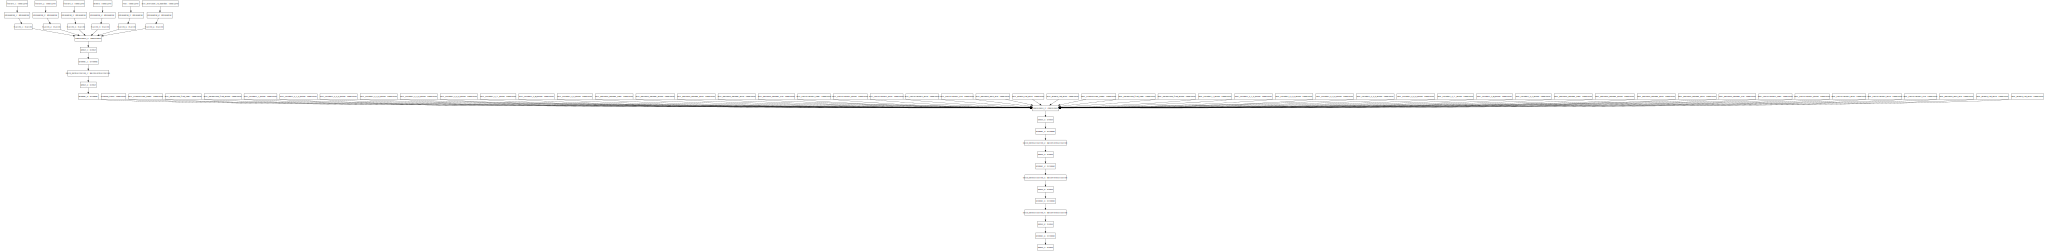

In [37]:
from keras.utils import plot_model
plot_model(keras_model, to_file='model.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(keras_model).create(prog='dot', format='svg'))

In [40]:
batch_size = 64
epochs = 10
hist = train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_val, reduce_lr=True, patience=7)

Train on 181725 samples, validate on 20192 samples
Epoch 1/10
181725/181725 [==============================] - 47s 256us/step - loss: 3.3085 - rmse: 3.3085 - val_loss: 3.4857 - val_rmse: 3.4857

Epoch 00001: val_loss improved from inf to 3.48572, saving model to model.hdf5
Epoch 2/10
181725/181725 [==============================] - 47s 257us/step - loss: 3.2872 - rmse: 3.2872 - val_loss: 3.4798 - val_rmse: 3.4798

Epoch 00002: val_loss improved from 3.48572 to 3.47980, saving model to model.hdf5
Epoch 3/10
181725/181725 [==============================] - 46s 254us/step - loss: 3.2965 - rmse: 3.2965 - val_loss: 3.4789 - val_rmse: 3.4789

Epoch 00003: val_loss improved from 3.47980 to 3.47886, saving model to model.hdf5
Epoch 4/10
181725/181725 [==============================] - 47s 256us/step - loss: 3.2935 - rmse: 3.2935 - val_loss: 3.4698 - val_rmse: 3.4698

Epoch 00004: val_loss improved from 3.47886 to 3.46981, saving model to model.hdf5
Epoch 5/10
181725/181725 [===================

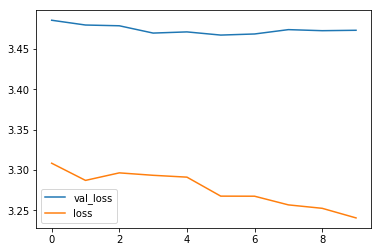

In [41]:
import matplotlib.pyplot as plt
#plotting training and validations losses
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.plot(hist.history['loss'], label = "loss")
plt.legend()

In [42]:
keras_modelmax = load_model("model.hdf5", custom_objects={'rmse': rmse})


In [43]:
y_pred_valid = keras_modelmax.predict(X_v)
valid_score = mean_squared_error(y_val,y_pred_valid)** 0.5
print("Validation score: ", valid_score)

Validation score:  3.89975168706127


In [44]:
predictions = keras_modelmax.predict(X_test_keras).reshape(-1,)

In [45]:
predictions

array([-1.9805    , -0.20730168, -0.5978606 , ...,  0.905292  ,
       -1.1232847 ,  0.33214226], dtype=float32)

In [ ]:
#saving the card_ids
ids = test['card_id'].values
submission = pd.DataFrame(ids, columns=['card_id'])

In [ ]:
submission['target'] = predictions
submission.head(10)

In [ ]:
submission.to_csv("submission_neuralnet.csv", index = False, header = True)

In [ ]:
print("done")